In [ ]:
# default_exp utils_gnn

In [ ]:
#hide
#all_ignoretest
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#hide
%cd '/content/drive/MyDrive/colab_notebooks/hmckd'
!pip3 install -e . -q

/content/drive/MyDrive/colab_notebooks/ckdhm


In [ ]:
#hide
!pip install fastai -Uqq
!pip3 install nbdev -q
!pip install torch-scatter -Uqq
!pip install torch-sparse -Uqq
!pip install torch-geometric -Uqq

     |████████████████████████████████| 186 kB 4.1 MB/s 
     |████████████████████████████████| 43 kB 784 kB/s 
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 376 kB 40.0 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 


In [ ]:
#hide
from nbdev.showdoc import *
from hmckd.utils import get_features
import networkx as nx
from fastai.tabular.all import *
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
#exporti
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.utils import to_networkx

# Building a GNN Model

> In this notebook, we will see if GNN help better our previous results

Graph NN has gained attention over the past few years especially in life sciencces with AlphaFold dominating the world of medical deep learing. 

For our task, graph seems like a natural fit since our data is "unstructured" tabular data. A simple search showed that Graph NN is a popular method for EHR data. For example the paper below reviews the recent developments in GNN and EHR data.



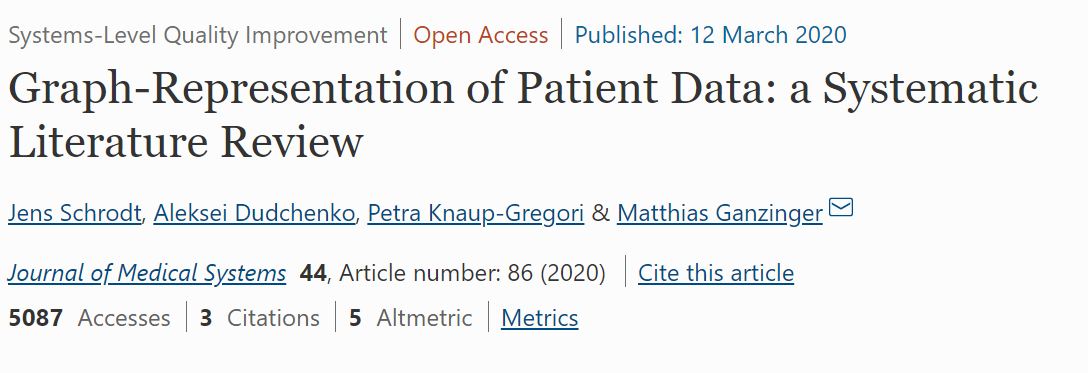

## Preparing data for GNN

In [ ]:
#hide
df = pd.read_csv('data/train_df_5f.csv')

We will first normalize the data and categorify the categorical columns.

In [ ]:
df['age'] = (df['age'] - df['age'].mean())/df['age'].std()

race2val = {'Unknown':0, 'White':0, 'Black':1, 'Asian':2, 'Hispanic':3}
df['race'] = df['race'].apply(lambda x: race2val[x])

gender2val = {'Male':0, 'Female':1}
df['gender'] = df['gender'].apply(lambda x: gender2val[x])

Prepare train and test df for each fold

In [ ]:
for i in range(5):
    df[df['fold']!=i].reset_index(drop=True).to_csv(f'data/gnn/raw/train_df_{i}.csv')
    df[df['fold']==i].reset_index(drop=True).to_csv(f'data/gnn/raw/test_df_{i}.csv')

Cut-off datapoints at 650 days from baseline and move the files to appropriate folder.

In [ ]:
features = get_features('data/dataScienceTask')
for k,v in features.items():
    v['value'] = (v['value'] - v['value'].mean())/v['value'].std()
    v=v[v['time'] < 650]
    v.to_csv(f'data/gnn/raw/{k}.csv')

Let's build our custom dataset.

In [ ]:
class CKDDataset(Dataset):
    def __init__(self, root, filename, fold, test=False, transform=None, pre_transform=None):

        self.filename = filename #filename of train/test df
        self.test = test      #True if its valid/test
        self.fold = fold      #fold

        super(CKDDataset, self).__init__(root,transform,pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]

    def process(self):
        
        self.demo = pd.read_csv(self.raw_paths[0])            
        self.hgb = pd.read_csv(f"{self.root}/raw/hgb.csv")
        self.ldl = pd.read_csv(f"{self.root}/raw/ldl.csv")
        self.glu = pd.read_csv(f"{self.root}/raw/glucose.csv")
        self.creat = pd.read_csv(f"{self.root}/raw/creatinine.csv")
        self.sbp = pd.read_csv(f"{self.root}/raw/sbp.csv")
        self.dbp = pd.read_csv(f"{self.root}/raw/dbp.csv")
        #self.stg = pd.read_csv(f"{self.root}/raw/stg.csv")

        for i,pat in enumerate(self.demo.id.unique()):
            patdemo = self.demo[self.demo['id'] == pat]
            pathgb = self.hgb[self.hgb['id'] == pat]
            patldl = self.ldl[self.ldl['id'] == pat]
            patglu = self.glu[self.glu['id'] == pat]
            patcreat = self.creat[self.creat['id'] == pat]
            patsbp = self.sbp[self.sbp['id'] == pat]
            patdbp = self.dbp[self.dbp['id'] == pat]

            # Get node features
            node_feats = self._get_node_features(patdemo, pathgb, patldl, patglu, patcreat, patsbp, patdbp)
            # Get edge features
            edge_feats = self._get_edge_features(patdemo, pathgb, patldl, patglu, patcreat, patsbp, patdbp)
            # Get adjacency info
            edge_index = self._get_adjacency_info(edge_feats, patdemo, pathgb, patldl, patglu, patcreat, patsbp, patdbp)
            # Get labels info
            label = self._get_labels(pat, self.demo)

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label)   
            
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{self.fold}_{i}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{self.fold}_{i}.pt'))

    def _get_node_features(self, patdemo, pathgb, patldl, patglu, patcreat, patsbp, patdbp):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        allnodefeat = []
        nodefeat = []
        #feats for zeroth or demo node
        [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
        nodefeat.append(0)
        allnodefeat.append(nodefeat)

        #nodes for hgb
        for v in pathgb.value.values:
            nodefeat = []
            [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
            nodefeat.append(v)
            allnodefeat.append(nodefeat)

        #nodes for ldl
        for v in patldl.value.values:
            nodefeat = []
            [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
            nodefeat.append(v)
            allnodefeat.append(nodefeat)

        #nodes for glu
        for v in patglu.value.values:
            nodefeat = []
            [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
            nodefeat.append(v)
            allnodefeat.append(nodefeat)

        #nodes for creat
        for v in patcreat.value.values:
            nodefeat = []
            [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
            nodefeat.append(v)
            allnodefeat.append(nodefeat)
        
        #nodes for sbp
        for v in patsbp.value.values:
            nodefeat = []
            [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
            nodefeat.append(v)
            allnodefeat.append(nodefeat)

        #nodes for dbp
        for v in patdbp.value.values:
            nodefeat = []
            [nodefeat.append(e) for e in patdemo[['age', 'gender', 'race']].values[0]]
            nodefeat.append(v)
            allnodefeat.append(nodefeat)

        allnodefeat = np.asarray(allnodefeat)
        return torch.tensor(allnodefeat, dtype=torch.float)

    def _get_edge_features(self, patdemo, pathgb, patldl, patglu, patcreat, patsbp, patdbp):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        #edge features
        alledgefeats = []
        alledgefeats.append([0])

        pathgbedge = pathgb.time.values
        for i,e in enumerate(pathgbedge):
            if i >0:
                edgefeat = [(pathgbedge[i] - pathgbedge[i-1])/700]
                alledgefeats.append(edgefeat)

        alledgefeats.append([0])
        patldledge = patldl.time.values
        for i,e in enumerate(patldledge):
            if i >0:
                edgefeat = [(patldledge[i] - patldledge[i-1])/700]
                alledgefeats.append(edgefeat)

        alledgefeats.append([0])
        patgluedge = patglu.time.values
        for i,e in enumerate(patgluedge):
            if i >0:
                edgefeat = [(patgluedge[i] - patgluedge[i-1])/700]
                alledgefeats.append(edgefeat)

        alledgefeats.append([0])
        patcreatedge = patcreat.time.values
        for i,e in enumerate(patcreatedge):
            if i >0:
                edgefeat = [(patcreatedge[i] - patcreatedge[i-1])/700]
                alledgefeats.append(edgefeat)

        alledgefeats.append([0])
        patsbpedge = patsbp.time.values
        for i,e in enumerate(patsbpedge):
            if i >0:
                edgefeat = [(patsbpedge[i] - patsbpedge[i-1])/700]
                alledgefeats.append(edgefeat)

        alledgefeats.append([0])
        patdbpedge = patdbp.time.values
        for i,e in enumerate(patdbpedge):
            if i >0:
                edgefeat = [(patdbpedge[i] - patdbpedge[i-1])/700]
                alledgefeats.append(edgefeat)
        
        alledgefeats = np.asarray(alledgefeats)
        return torch.tensor(alledgefeats, dtype=torch.float)

    def _get_adjacency_info(self, edge_feats, patdemo, pathgb, patldl, patglu, patcreat, patsbp, patdbp):
        """
        matric shape --> (len(node)-1, 2)
        """
        edgeindices = np.zeros((edge_feats.shape[0], 2))
        nodes = {'demo':1, 
                'hgb':len(pathgb),
                'ldl':len(patldl),
                'glu':len(patglu),
                'creat':len(patcreat),
                'sbp':len(patsbp),
                'dbp':len(patdbp)}
        zeb = 1
        fib = zeb+len(pathgb)
        seb = fib+len(patldl)
        thb = seb+len(patglu)
        fob = thb+len(patcreat)
        fivb = fob+len(patsbp)
        sib = fivb+len(patdbp)

        edgeindices[0] = [0,1]
        edgeindices[1] = [0,fib]
        edgeindices[2] = [0,seb]
        edgeindices[3] = [0,thb]
        edgeindices[4] = [0,fob]
        edgeindices[5] = [0,fivb]

        curr_idx = 6+nodes['hgb']-1
        edgeindices[6: curr_idx, 0] = [e for e in range(zeb, fib-1)]
        edgeindices[6: curr_idx, 1] = [e for e in range(zeb+1,fib)]

        edgeindices[curr_idx:curr_idx+nodes['ldl']-1, 0] = [e for e in range(fib, seb-1)]
        edgeindices[curr_idx:curr_idx+nodes['ldl']-1, 1] = [e for e in range(fib+1,seb)]
        curr_idx = curr_idx+nodes['ldl']-1

        edgeindices[curr_idx:curr_idx+nodes['glu']-1, 0] = [e for e in range(seb, thb-1)]
        edgeindices[curr_idx:curr_idx+nodes['glu']-1, 1] = [e for e in range(seb+1,thb)]
        curr_idx = curr_idx+nodes['glu']-1

        edgeindices[curr_idx:curr_idx+nodes['creat']-1, 0] = [e for e in range(thb, fob-1)]
        edgeindices[curr_idx:curr_idx+nodes['creat']-1, 1] = [e for e in range(thb+1,fob)]
        curr_idx = curr_idx+nodes['creat']-1

        edgeindices[curr_idx:curr_idx+nodes['sbp']-1, 0] = [e for e in range(fob, fivb-1)]
        edgeindices[curr_idx:curr_idx+nodes['sbp']-1, 1] = [e for e in range(fob+1,fivb)]
        curr_idx = curr_idx+nodes['sbp']-1


        edgeindices[curr_idx:curr_idx+nodes['dbp']-1, 0] = [e for e in range(fivb, sib-1)]
        edgeindices[curr_idx:curr_idx+nodes['dbp']-1, 1] = [e for e in range(fivb+1,sib)]
        curr_idx = curr_idx+nodes['dbp']-1

        edgeindices = torch.tensor(edgeindices)
        edgeindices = edgeindices.t().to(torch.long).view(2, -1)
        return edgeindices

    def _get_labels(self, pat, demo):
        label = int(demo[demo['id']==pat]['Stage_Progress'].values[0])
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{self.fold}_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{self.fold}_{idx}.pt'))   
        return data


In [ ]:
#hide_input
train_dataset = CKDDataset(root='data/gnn', filename='train_df_0.csv', fold=0)

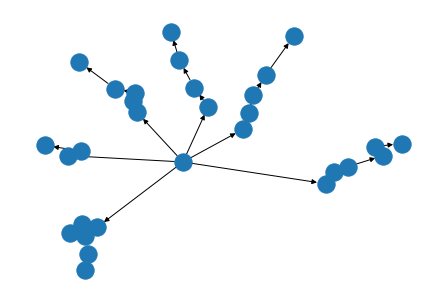

In [ ]:
#hide_input
x = train_dataset[0]
g = to_networkx(x)
nx.draw(g)

The above is how we could define our problem.

The center node, which we call the demographic node, carries the demographic information and is connected to all other branches. Each branch corresponds to single lab measurement type such as HGB. The nodes along the branch is the lab measurement entries. The weight of the edge represent the time since baseline. 

All nodes have four features - age, gender, race and value. For demographic node, value feature will be zero. For other nodes, value represent the lab measurement value at corresponsing time point.

Although I did not proceed further with this approach, representing our task as a graph task holds potential as noted from literature review. Not only graph approach allows for classification of patient progressing in their CKD Staging, we could also set it up to predict the timepoint at which the patient might progress in their CKD.

Below is a potential set up of our GNN with three message passing layers. 

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self,train_dataset):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(train_dataset.num_features, 100)
        self.conv2 = GCNConv(100, 50)
        self.conv3 = GCNConv(50, 25)

        self.linear = Linear(25, 10)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()
        self.classifier = Linear(10, 2)

    def forward(self, x, edge_attr, edge_index, batch):
        h = self.conv1(x, edge_index, edge_weight=edge_attr.squeeze())
        h = h.relu()
        h = self.conv2(h, edge_index, edge_weight=edge_attr.squeeze())
        h = h.relu()
        h = self.conv3(h, edge_index, edge_weight=edge_attr.squeeze())

        hp = global_mean_pool(h, batch)
        
        out = self.linear(hp)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.classifier(out)

        return out, h

In [ ]:
#hide
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, device):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(train_loader):
        batch.to(device)  

        optimizer.zero_grad() 

        pred = model(batch.x.float(), 
                     batch.edge_attr.float(),
                     batch.edge_index,
                     batch.batch) 

        loss = loss_fn(pred[0], batch.y)
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()
        step += 1

        all_preds.append(torch.argmax(pred[0], 1).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    #calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step, all_preds, all_labels

In [ ]:
#hide
def test(epoch, model, test_loader, loss_fn, device):
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        pred = model(batch.x.float(), 
                        batch.edge_attr.float(),
                        batch.edge_index, 
                        batch.batch) 
        loss = loss_fn(pred[0], batch.y)

         # Update tracking
        running_loss += loss.item()
        step += 1
        
        all_preds.append(torch.argmax(pred[0], 1).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    #calculate_metrics(all_preds, all_labels, epoch, "test")
    return running_loss/step, all_preds, all_labels

In [ ]:
#hide
def run_one_training(params):

    # Loading the dataset
    print("Loading dataset...")
    train_dataset = CKDDataset(root=params['root'], filename=params['fn_train'], fold=params['fold'])
    test_dataset = CKDDataset(root=params['root'], filename=params['fn_test'], fold=params['fold'], test=True)

    # Prepare dataloader
    train_loader = DataLoader(train_dataset, batch_size=params['bs'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['bs'], shuffle=True)

    # Loading the model
    print("Loading model...")
    model = GCN(train_dataset)
    model = model.to(params['device'])

    loss_fn = CrossEntropyLossFlat()
    optimizer = torch.optim.SGD(model.parameters(), 
                                lr=params["lr"],
                                momentum=params["moms"],
                                weight_decay=params["wd"])
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1e-1)
    
    # Start training
    for epoch in range(params['epochs']): 
        # Training
        model.train()
        train_loss, _, _ = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, params['device'])

        # Testing
        model.eval()
        valid_loss, y_preds, y_test = test(epoch, model, test_loader, loss_fn, params['device'])
        acc = accuracy_score(y_preds, y_test)
   
        print(f"Epoch {epoch} | Train Loss {train_loss:.2f} | Test Loss {valid_loss:.2f} | Test Accuracy {acc:.2f}")     
                
        scheduler.step()

    return y_preds, y_test, acc